/home/mobrrei/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]


Original model parameters: 6,738,415,616

--- Simulating Truncation and Calculating Parameters ---
Truncating model.layers.0.self_attn.q_proj to rank 316
Truncating model.layers.0.self_attn.k_proj to rank 274
Truncating model.layers.0.self_attn.v_proj to rank 698
Truncating model.layers.0.self_attn.o_proj to rank 760
Truncating model.layers.0.mlp.gate_proj to rank 1244
Truncating model.layers.0.mlp.up_proj to rank 1288
Truncating model.layers.0.mlp.down_proj to rank 1222
Truncating model.layers.1.self_attn.q_proj to rank 802
Truncating model.layers.1.self_attn.k_proj to rank 406
Truncating model.layers.1.self_attn.v_proj to rank 1204
Truncating model.layers.1.self_attn.o_proj to rank 928
Truncating model.layers.1.mlp.gate_proj to rank 1678
Truncating model.layers.1.mlp.up_proj to rank 1598
Truncating model.layers.1.mlp.down_proj to rank 1432
Truncating model.layers.2.self_attn.q_proj to rank 598
Truncating model.layers.2.self_attn.k_proj to rank 542
Truncating model.layers.2.self_attn.

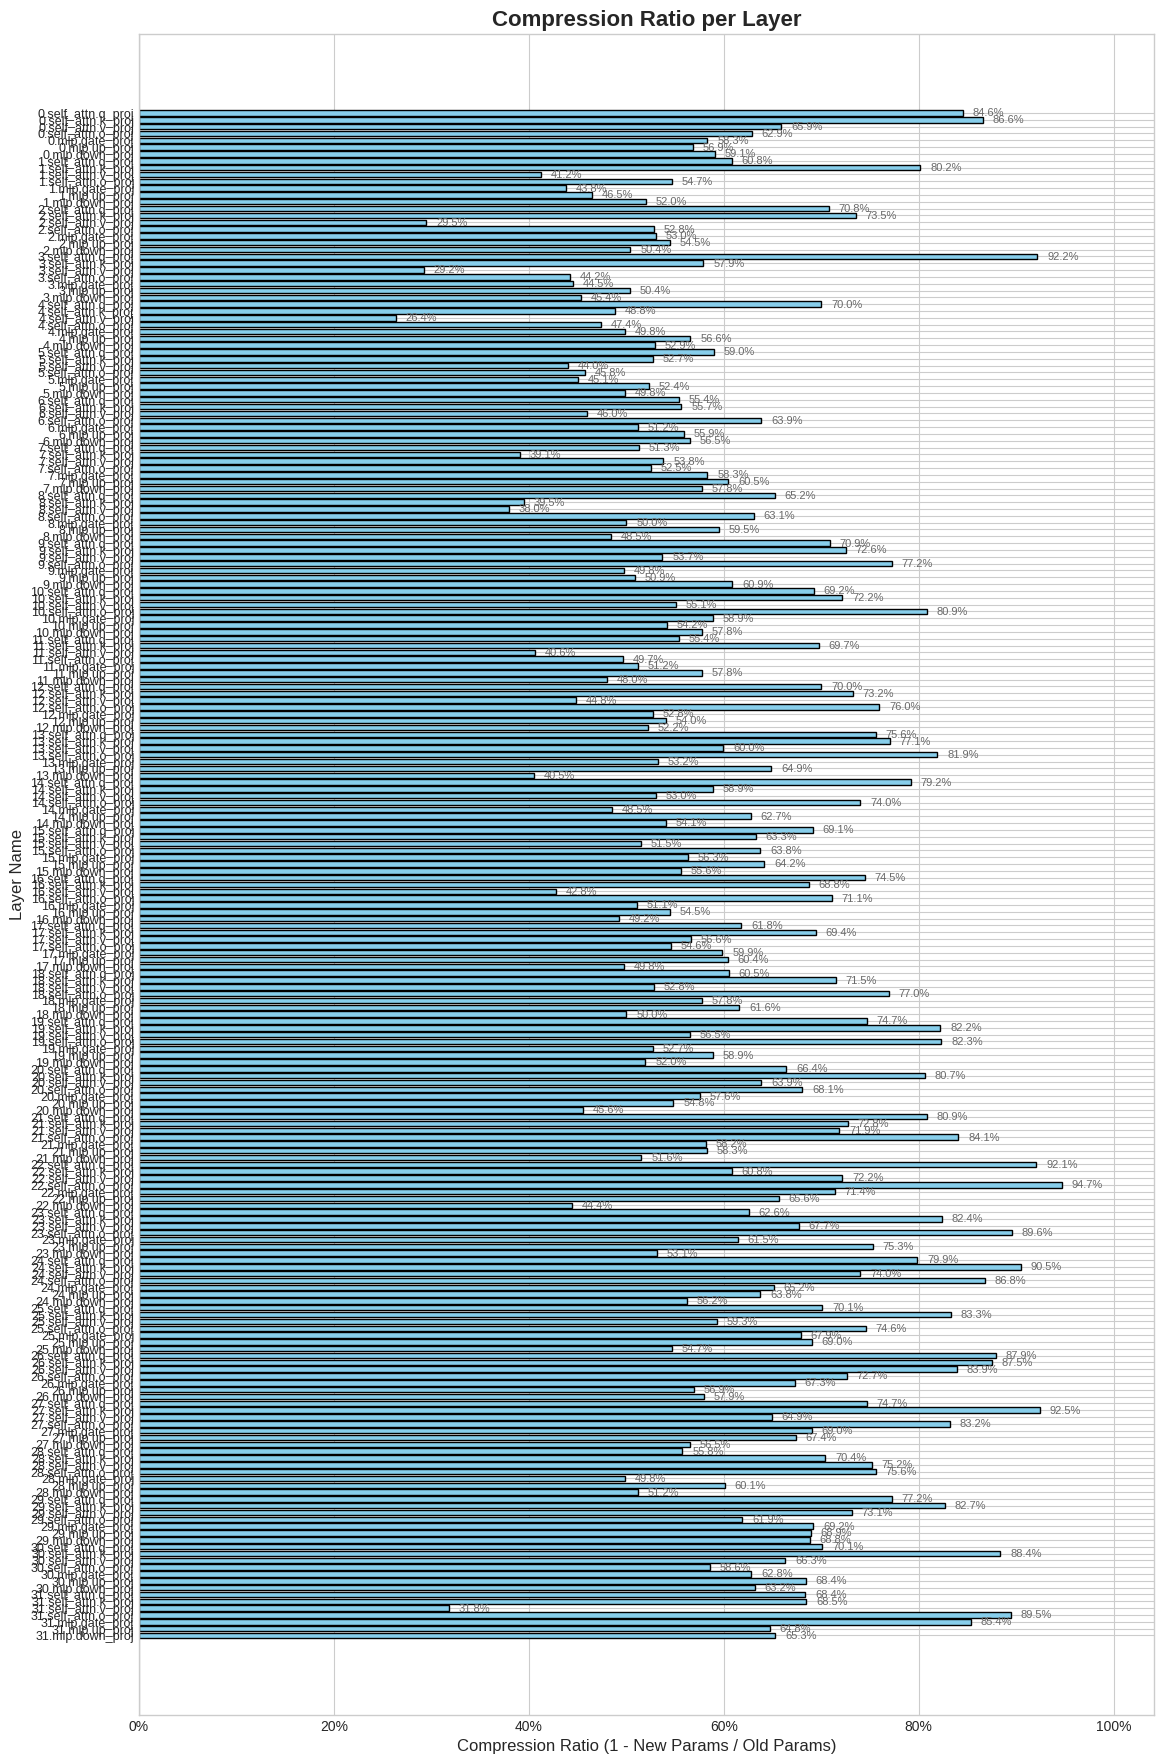

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
import gc
import json
import math
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup and Model Loading ---

SEQ_LEN = 2048

# Load the dictionary with dynamic ranks
# Make sure the path to your JSON file is correct
try:
    rank_dics = json.load(open('dynamic_ranks/llama7b_0.4.json', 'r'))
except FileNotFoundError:
    print("Error: The rank dictionary file 'dynamic_ranks/llama7b_0.4.json' was not found.")
    print("Please ensure the file exists or create a dummy one for demonstration.")
    # Create a dummy rank_dics for demonstration purposes if the file doesn't exist
    rank_dics = {f'model.layers.{i}.mlp.gate_proj': 1024 for i in range(32)}
    rank_dics.update({f'model.layers.{i}.mlp.up_proj': 512 for i in range(32)})


# Load the pre-trained model
model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    torch_dtype=torch.float16,
    device_map="cpu",
)

og_total_params = sum(p.numel() for p in model.parameters())
print(f"Original model parameters: {og_total_params:,}")

# Dictionaries to store parameter counts for comparison
og_params_per_layer = {}
new_params_per_layer = {}

# --- 2. Model Truncation Simulation ---

print("\n--- Simulating Truncation and Calculating Parameters ---")
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        og_params_per_layer[name] = module.weight.numel()
        if name in rank_dics:
            gamma = math.ceil(rank_dics[name])
            m, n = module.weight.shape
            cut = min(n, m) / SEQ_LEN
            if cut > 1:
                real_gamma = min(m, n, max(1, cut * math.ceil(gamma)))
            else:
                real_gamma = min(m, n, max(1, math.ceil(gamma)))

            real_gamma = int(real_gamma)

            print(f"Truncating {name} to rank {real_gamma}")
            
            # The new number of parameters is rank * (rows + columns)
            # No need to perform the actual SVD for this calculation
            new_params_per_layer[name] = real_gamma * (m + n)
        else:
            # If a layer is not in rank_dics, it's not compressed.
            # Its new parameter count is the same as the old one.
            new_params_per_layer[name] = module.weight.numel()
            print(f"No rank info for {name}, skipping truncation.")

# --- 3. Calculate Overall Compression ---

print("\n--- Calculating Final Compression ---")

# Note: This calculation assumes biases are negligible or part of the non-weight parameters.
# For a more precise calculation, you could add bias parameters if they exist.
new_total_params = sum(new_params_per_layer.values())
compression_ratio = 1.0 - (new_total_params / sum(og_params_per_layer.values()))

print(f"Original total linear parameters: {sum(og_params_per_layer.values()):,}")
print(f"New total linear parameters: {new_total_params:,}")
print(f"Achieved Compression Ratio on Linear Layers: {compression_ratio:.2%}")


# --- 4. Prepare Data and Generate the Plot ---

print("\n--- Generating Compression Plot ---")

# Prepare data for plotting, maintaining original order and skipping lm_head
layer_names = []
compression_values = []
for name, og_params in og_params_per_layer.items():
    # Skip the lm_head layer as requested
    if 'lm_head' in name:
        print(f"Skipping {name} from plot.")
        continue

    if name in new_params_per_layer:
        new_params = new_params_per_layer[name]
        # Ensure we don't divide by zero
        if og_params > 0:
            ratio = 1.0 - (new_params / og_params)
            layer_names.append(name)
            compression_values.append(ratio)

# Shorten the layer names for better readability on the plot's Y-axis
# e.g., "model.layers.15.mlp.gate_proj" -> "15.mlp.gate_proj"
short_names = [name.replace('model.layers.', '') for name in layer_names]

# Create the horizontal bar plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 18))

# Plot the data
y_pos = np.arange(len(short_names))
ax.barh(y_pos, compression_values, align='center', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_yticks(y_pos)
ax.set_yticklabels(short_names, fontsize=9)
ax.invert_yaxis()  # Invert y-axis to have the highest compression at the top
ax.set_xlabel('Compression Ratio (1 - New Params / Old Params)', fontsize=12)
ax.set_ylabel('Layer Name', fontsize=12)
ax.set_title('Compression Ratio per Layer', fontsize=16, fontweight='bold')

# Add a vertical line at 0 for reference
ax.axvline(0, color='grey', linewidth=0.8)

# Set x-axis to be formatted as percentage
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.set_xlim(left=min(0, min(compression_values)*1.1), right=max(compression_values)*1.1)


# Add value labels on each bar for clarity
for i, v in enumerate(compression_values):
    ax.text(v + 0.01, i, f'{v:.1%}', color='dimgray', va='center', fontsize=8)


plt.tight_layout(pad=2)
plt.show()



In [2]:
from collections import OrderedDict

# Load the gradients to verify
with open("grads/llama7b_grads_out.pt", "rb") as f:
    importance_dict = torch.load(f)

# Calculate the average importance of each layer
importance_avg = OrderedDict()
for layer_name, importance in importance_dict.items():
    importance_avg[layer_name] = torch.mean(importance).item()
    
print(importance_avg)

OrderedDict([('model.layers.31.mlp.down_proj', 0.38671875), ('model.layers.31.mlp.up_proj', 0.029998779296875), ('model.layers.31.mlp.gate_proj', 0.04534912109375), ('model.layers.31.self_attn.o_proj', 0.677734375), ('model.layers.31.self_attn.v_proj', 0.1424560546875), ('model.layers.31.self_attn.k_proj', 0.03863525390625), ('model.layers.31.self_attn.q_proj', 0.04095458984375), ('model.layers.30.mlp.down_proj', 0.482666015625), ('model.layers.30.mlp.up_proj', 0.0257720947265625), ('model.layers.30.mlp.gate_proj', 0.08050537109375), ('model.layers.30.self_attn.o_proj', 0.3828125), ('model.layers.30.self_attn.v_proj', 0.2001953125), ('model.layers.30.self_attn.k_proj', 0.032012939453125), ('model.layers.30.self_attn.q_proj', 0.0307769775390625), ('model.layers.29.mlp.down_proj', 0.3876953125), ('model.layers.29.mlp.up_proj', 0.0638427734375), ('model.layers.29.mlp.gate_proj', 0.054290771484375), ('model.layers.29.self_attn.o_proj', 0.364013671875), ('model.layers.29.self_attn.v_proj', 

In [22]:
import numpy as np

def get_dynamic_ranks(importance_dict, layer_dims, target_ratio, alpha=0.75):
    """
    Calculates dynamic ranks for SVD compression.

    Args:
        importance_dict (dict): {layer_name: importance_score}
        layer_dims (dict): {layer_name: (m, n)}
        target_ratio (float): Desired overall compression ratio.
        alpha (float): Smoothing factor for importance scores.

    Returns:
        dict: {layer_name: allocated_rank}
    """
    layer_names = list(importance_dict.keys())
    
    # 1. Apply smoothing factor and get shaped importance scores
    importances = np.array([importance_dict[name]**alpha for name in layer_names])
    
    # Normalize importances
    normalized_importances = importances / np.sum(importances)
    
    # 2. Calculate parameter budget
    p_orig = sum(layer_dims[name][0] * layer_dims[name][1] for name in layer_names)
    p_target = p_orig * target_ratio
    
    # 3. Initial float rank allocation
    ranks_float = {}
    for i, name in enumerate(layer_names):
        m, n = layer_dims[name]
        budget = p_target * normalized_importances[i]
        ranks_float[name] = budget / (m + n)

    # 4. Round to initial integer ranks
    ranks_int = {name: max(1, int(round(k))) for name, k in ranks_float.items()}
    for name, (m, n) in layer_dims.items():
        ranks_int[name] = min(ranks_int[name], m, n)

    # 5. Greedy iterative adjustment
    def get_current_params(ranks):
        return sum(ranks[name] * (layer_dims[name][0] + layer_dims[name][1]) for name in layer_names)

    current_params = get_current_params(ranks_int)
    
    # Sort layers by importance for adjustments
    sorted_layers_asc = sorted(layer_names, key=lambda name: importance_dict[name])
    sorted_layers_desc = sorted_layers_asc[::-1]

    # Adjust down if we are over budget
    while current_params > p_target:
        # Find least important layer to decrement
        found_layer = False
        for name in sorted_layers_asc:
            if ranks_int[name] > 1:
                ranks_int[name] -= 1
                current_params = get_current_params(ranks_int)
                found_layer = True
                break
        if not found_layer: break # Can't reduce further

    # Adjust up if we are under budget
    while current_params < p_target:
        # Find most important layer to increment
        found_layer = False
        for name in sorted_layers_desc:
            m, n = layer_dims[name]
            if ranks_int[name] < min(m, n):
                ranks_int[name] += 1
                current_params = get_current_params(ranks_int)
                found_layer = True
                break
        if not found_layer: break # Can't increase further
        
    final_ratio = get_current_params(ranks_int) / p_orig
    print(f"Target Ratio: {target_ratio:.4f}, Achieved Ratio: {final_ratio:.4f}")

    return ranks_int

# Test the function with example data

model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    torch_dtype=torch.float16,
    device_map="cpu",
)
# Skip lm_head layer
layer_dims = {}
for name, module in model.named_modules():
    if isinstance(module, nn.Linear) and 'lm_head' not in name:
        layer_dims[name] = module.weight.shape

from collections import OrderedDict

# Load the gradients to verify
with open("grads/llama7b_gradsppl_out.pt", "rb") as f:
    importance_dict = torch.load(f)

# Calculate the average importance of each layer
importance_avg = OrderedDict()
for layer_name, importance in importance_dict.items():
    importance_avg[layer_name] = torch.mean(importance).item()
    
final_ranks = get_dynamic_ranks(importance_avg, layer_dims, target_ratio=0.4, alpha=0.1)
print(final_ranks)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

Target Ratio: 0.4000, Achieved Ratio: 0.4000
{'model.layers.31.mlp.down_proj': 855, 'model.layers.31.mlp.up_proj': 661, 'model.layers.31.mlp.gate_proj': 689, 'model.layers.31.self_attn.o_proj': 1670, 'model.layers.31.self_attn.v_proj': 1424, 'model.layers.31.self_attn.k_proj': 1254, 'model.layers.31.self_attn.q_proj': 1247, 'model.layers.30.mlp.down_proj': 873, 'model.layers.30.mlp.up_proj': 646, 'model.layers.30.mlp.gate_proj': 729, 'model.layers.30.self_attn.o_proj': 1572, 'model.layers.30.self_attn.v_proj': 1476, 'model.layers.30.self_attn.k_proj': 1229, 'model.layers.30.self_attn.q_proj': 1223, 'model.layers.29.mlp.down_proj': 853, 'model.layers.29.mlp.up_proj': 711, 'model.layers.29.mlp.gate_proj': 701, 'model.layers.29.self_attn.o_proj': 1565, 'model.layers.29.self_attn.v_proj': 1568, 'model.layers.29.self_attn.k_proj': 1250, 'model.layers.29.self_attn.q_proj': 1282, 'model.layers.28.mlp.down_proj': 850, 'model.layers.28.mlp.up_proj': 724, 'model.layers.28.mlp.gate_proj': 736, 'm

In [23]:
# Compare final ranks with compression_values

for name, rank in final_ranks.items():
    print(f"Gradient importance for {name}: {importance_avg.get(name, 'N/A')}")
    print(f"New rank for {name} in gradient-based allocation: {rank}")
    print(f"New rank for {name} in dobisvd-based allocation: {math.ceil(rank_dics[name]*2)}")
    print(f"---")

Gradient importance for model.layers.31.mlp.down_proj: 0.392578125
New rank for model.layers.31.mlp.down_proj in gradient-based allocation: 855
New rank for model.layers.31.mlp.down_proj in dobisvd-based allocation: 1035
---
Gradient importance for model.layers.31.mlp.up_proj: 0.0299224853515625
New rank for model.layers.31.mlp.up_proj in gradient-based allocation: 661
New rank for model.layers.31.mlp.up_proj in dobisvd-based allocation: 1051
---
Gradient importance for model.layers.31.mlp.gate_proj: 0.0452880859375
New rank for model.layers.31.mlp.gate_proj in gradient-based allocation: 689
New rank for model.layers.31.mlp.gate_proj in dobisvd-based allocation: 436
---
Gradient importance for model.layers.31.self_attn.o_proj: 0.677734375
New rank for model.layers.31.self_attn.o_proj in gradient-based allocation: 1670
New rank for model.layers.31.self_attn.o_proj in dobisvd-based allocation: 216
---
Gradient importance for model.layers.31.self_attn.v_proj: 0.14208984375
New rank for mo